In [141]:
cd Documents/TP_text/

[Errno 2] No such file or directory: 'Documents/TP_text/'
/Users/sara/Documents/TP_text/data


In [430]:
import os.path as op
import numpy as np
import codecs
import pandas as pd 
import numpy as np 
import nltk 
import re
import string
from nltk.stem.snowball import FrenchStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize.texttiling import TextTilingTokenizer
from nltk.collocations import *
import urllib
import requests
import json
import unicodedata
import os
from nltk.stem import WordNetLemmatizer
%matplotlib inline
from sklearn.base import BaseEstimator, ClassifierMixin

In [431]:
cd data/

[Errno 2] No such file or directory: 'data/'
/Users/sara/Documents/TP_text/data


In [432]:
###############################################################################
# Load data
print("Loading dataset")

from glob import glob
filenames_neg = sorted(glob(op.join('..', 'data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(op.join('..', 'data', 'imdb1', 'pos', '*.txt')))

texts_neg = [open(f).read() for f in filenames_neg]
texts_pos = [open(f).read() for f in filenames_pos]
texts = texts_neg + texts_pos
y = np.ones(len(texts), dtype=np.int)
y[:len(texts_neg)] = 0.

print("%d documents" % len(texts))

############################################

Loading dataset
2000 documents


Build the classifier : 

In [433]:
def chunk_mot(phrases):
    """split text to a set of words : bag-of-words"""
    mots = nltk.word_tokenize(phrases) 
    return mots 

def no_punctuation(mots):
    """return the set of words without puntctuation marks """
    regex =  re.compile('[%s]' % re.escape(string.punctuation))
    mots_no_punctuation = []
    for token in mots: 
        new_token = regex.sub(u'', token)
        if not new_token == u'':
            mots_no_punctuation.append(new_token.lower()) #lower pour normaliser le texte
    return mots_no_punctuation

def delete_stop_words(mots):
    """return the set of words without insignifiant words like : le , de, ces, the... 
    """
    stops= set(stopwords.words('french')+stopwords.words('english'))
    mots_no_stopwords = []
    for mot in mots:
        if not mot in stops:
                mots_no_stopwords.append(mot)
    return mots_no_stopwords

def word_stemmer(mots, ):
    snowball = SnowballStemmer('english') # for english use Porter stem algo
    preprocessed_docs = []
    for mot in mots:
        preprocessed_docs.append(snowball.stem(mot))   
    return preprocessed_docs

def word_lemmatizer(mots): 
    lemmat = WordNetLemmatizer()
    preprocessed_docs = []
    for mot in mots:
        preprocessed_docs.append(lemmat.lemmatize(mot))   
    return preprocessed_docs 
    
def clean_text(text, lemma = False, stemm = False ): 
    text_chunk = chunk_mot(text)
    text_punct = no_punctuation(text_chunk)
    text_f = delete_stop_words(text_punct)
    if lemma:
        text_f = word_lemmatizer(text_f)
    if stemm: 
        text_f = word_stemmer(text_f)
    #reconstruct the text
    textn = ' '.join(text_f)
    return textn

**1st Step : Clean the documents **

In [434]:
texts[1]

'the happy bastard\'s quick movie review \ndamn that y2k bug . \nit\'s got a head start in this movie starring jamie lee curtis and another baldwin brother ( william this time ) in a story regarding a crew of a tugboat that comes across a deserted russian tech ship that has a strangeness to it when they kick the power back on . \nlittle do they know the power within . . . \ngoing for the gore and bringing on a few action sequences here and there , virus still feels very empty , like a movie going for all flash and no substance . \nwe don\'t know why the crew was really out in the middle of nowhere , we don\'t know the origin of what took over the ship ( just that a big pink flashy thing hit the mir ) , and , of course , we don\'t know why donald sutherland is stumbling around drunkenly throughout . \nhere , it\'s just " hey , let\'s chase these people around with some robots " . \nthe acting is below average , even from the likes of curtis . \nyou\'re more likely to get a kick out of h

In [435]:
texts = map(clean_text,texts)

In [436]:
texts[1]

u'happy bastard quick movie review damn y2k bug got head start movie starring jamie lee curtis another baldwin brother william time story regarding crew tugboat comes across deserted russian tech ship strangeness kick power back little know power within going gore bringing action sequences virus still feels empty like movie going flash substance nt know crew really middle nowhere nt know origin took ship big pink flashy thing hit mir course nt know donald sutherland stumbling around drunkenly throughout hey let chase people around robots acting average even likes curtis re likely get kick work halloween h20 sutherland wasted baldwin well acting like baldwin course real star stan winston robot design schnazzy cgi occasional good gore shot like picking someone brain robots body parts really turn movie otherwise pretty much sunken ship movie'

**2ndstep : construct the vocab & define the sparse matrix count **

In [437]:
from sklearn.feature_extraction.text import TfidfVectorizer
def count_words(texts,max_df,min_df):
    """Vectorize text : return count of each word in the text snippets
    Parameters
    ----------
    texts : list of str
        The texts (documents)
    max_df :
    min_df : 

    Returns
    -------
    vocabulary : array that contains the list of words.
    counts : ndarray, shape (n_samples, n_features) : sparse matrix 
        The counts of each word in each text.
        n_samples == number of documents.
        n_features == number of words in vocabulary.
    """
    #texts = map(clean_text,texts)  #----if the text is not already cleaned 
    vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df)
    counts = vectorizer.fit_transform(texts)
    vocabulary = np.array(vectorizer.get_feature_names())
    return counts, vocabulary

In [619]:
X,vocabulary = count_words(texts,0.8,3)

In [620]:
X

<2000x18813 sparse matrix of type '<type 'numpy.float64'>'
	with 495929 stored elements in Compressed Sparse Row format>

**3rd step : Reduce the vocabulary and the sparse matrix : CHi-2 test **

In [256]:
from sklearn.feature_selection import SelectKBest, chi2
def chi2_test(X, y,vocabulary, k):
    """Vectorize text : return count of each word in the text snippets
    Parameters
    ----------
    X: sparse matrix : bag-of-words
    y: the labels vector : class of each document
    vocabulary : array that contains the list of words.
    k : integer to set the k-most informative features 

    Returns
    -------
    X: sparse matrix of the k-best words
    vocabulary : array
        
    counts : ndarray, shape (n_samples, n_features) : sparse matrix 
        The counts of each word in each text.
        n_samples == number of documents.
        n_features == number of words in vocabulary.
    """
    print("Extracting %d best features by a chi-squared test" % k)
    ch2 = SelectKBest(chi2, k=k)
    X = ch2.fit_transform(X, y)
    'keep selected feature names'
    vocabulary = [vocabulary[i] for i in ch2.get_support(indices=True)]
    return X, vocabulary

In [257]:
X,vocabulary = chi2_test(X,y,vocabulary,2000)

Extracting 2000 best features by a chi-squared test


In [258]:
X

<2000x2000 sparse matrix of type '<type 'numpy.float64'>'
	with 91379 stored elements in Compressed Sparse Row format>

In [314]:
X.shape[1]

18813

In [277]:
y.shape

(2000,)

**How to set k ? **

In [440]:
from sklearn.cross_validation import cross_val_score
import operator
def set_k(clf,X,y,vocabulary):
    dicti={}
    n = X.shape[1]
    for k in np.arange(1000,n,1000):
        ch2 = SelectKBest(chi2, k=k)
        scores = cross_val_score(clf, ch2.fit_transform(X, y), y, scoring='accuracy', cv=5)
        dicti[k] = scores.mean()
        sorted_d = sorted(dicti.items(), key=operator.itemgetter(1))
    return sorted_d[-1][0]

In [441]:
set_k(clf,X,y,vocabulary)

3000

#Conclusion : Features_selection

In [416]:
clf = MultinomialNB()

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

given a classfier and a given dataset, the following code compute the k-best features related to this classfier

In [621]:
X,vocabulary = chi2_test(X,y,vocabulary,k=set_k(clf,X,y,vocabulary))

Extracting 3000 best features by a chi-squared test


In [622]:
X.shape

(2000, 3000)

**A benchmark of Classification **

In [390]:
#Benchmark of training and testing a classifier : 
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
from time import time
def benchmark(clf, X, y, learn_curve=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    categories = np.unique(y)
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    print("classification report:")
    print(metrics.classification_report(y_test, pred))

    def plot_learncurve(clf,X_train, y_train):
        """
        :param clf:
        :param x_train:
        :param y_train:
        :return:
        """
        print("learning curve:")
        train_sizes, train_scores, test_scores = learning_curve(estimator=clf,X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),cv=10,n_jobs=1)
        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
        plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
        plt.grid()
        plt.xlabel('Number of training samples')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.ylim([0, 1.0])
        plt.show()
      
        
    if learn_curve:
        plot_learncurve(clf, X_train, y_train)
        
    print("confusion matrix:")
    
    print(metrics.confusion_matrix(y_test, pred))
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

**Naive Bayes Classifier:**

________________________________________________________________________________
Training: 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
train time: 0.001s
test time:  0.000s
accuracy:   0.900
classification report:
             precision    recall  f1-score   support

          0       0.88      0.92      0.90       325
          1       0.92      0.88      0.90       335

avg / total       0.90      0.90      0.90       660

learning curve:


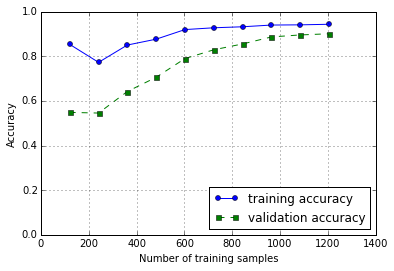

confusion matrix:
[[300  25]
 [ 41 294]]
()


('MultinomialNB',
 0.90000000000000002,
 0.0013380050659179688,
 0.0002720355987548828)

In [391]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
clf = MultinomialNB()
benchmark(clf, X, y, learn_curve=True)

*We can also have a probability score for each document:**

In [261]:
clf.predict_proba(X[2])

array([[ 0.67200116,  0.32799884]])

**Second Classifier : **

In [398]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
clf4 = PassiveAggressiveClassifier()
scores = cross_val_score(clf4,X,y, cv=10)
print('Score (optimiste) sur le train : %s' % scores)
print(scores.mean())

Score (optimiste) sur le train : [ 0.93   0.925  0.935  0.93   0.93   0.935  0.96   0.97   0.89   0.93 ]
0.9335


##Construct best classifier among the two best text classifiers :

In [405]:
import pickle
from sklearn.ensemble import VotingClassifier
def bestclassifier(clfs, x_train, y_train):
    """
    :param y_train: the labels of the training set
    :param x_train: the training features
    :param clfs: three best estimators choosen from previous methods
    :return: pickle's address for the classifier constructed from the combination of classifiers using majority class voting
    """
    vclf = VotingClassifier(estimators=clfs)
    vclf.fit(x_train,y_train)
    s = pickle.dumps(vclf)
    return vclf,s

In [565]:
clf4 = PassiveAggressiveClassifier()
clf = MultinomialNB()
c,s=bestclassifier([('naivebayes',clf),('passiveagressive',clf4)],X,y)

In [566]:
scores = cross_val_score(c,X,y, cv=10)
print('Score (optimiste) sur le train : %s' % scores)
print(scores.mean())

Score (optimiste) sur le train : [ 0.905  0.91   0.94   0.93   0.91   0.94   0.95   0.94   0.885  0.905]
0.9215


In [570]:
c.predict(X[1900])

array([1])

##Group the code in a class "Classifier"

In [488]:
X,vocabulary = count_words(texts,0.8,3)
X,vocabulary = chi2_test(X,y,vocabulary,k=set_k(clf,X,y,vocabulary))

Extracting 3000 best features by a chi-squared test


In [606]:
class NB(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=1.0,C=1.0,loss="hinge"):
        self.alpha = alpha
        self.C = C
        self.loss = loss
        
    def fit(self, X, y):
        c = MultinomialNB(self.alpha)
        c1 = PassiveAggressiveClassifier(self.C)
        clfs = [('naivebayes',c),('passiveagressive',c1)]
        self,s=bestclassifier(clfs,X,y)
        self.fit(X,y)
        return self
    
    def predict(self, X):
        pred = self.predict(X)
        return pred
    
    def predict_proba(self,X):
        return self.predict_proba(X)
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [613]:
N = NB(alpha=0.9,C=0.9)

In [614]:
N

NB(C=0.9, alpha=0.9, loss='hinge')

In [615]:
N=N.fit(X,y)

In [616]:
N.predict(X)

array([0, 0, 0, ..., 1, 1, 1])

In [617]:
scores = cross_val_score(N,X,y, cv=10)
print('Score (optimiste) sur le train : %s' % scores)
print(scores.mean())

Score (optimiste) sur le train : [ 0.905  0.92   0.94   0.93   0.905  0.935  0.955  0.935  0.88   0.9  ]
0.9205


________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('naivebayes', MultinomialNB(alpha=0.9, class_prior=None, fit_prior=True)), ('passiveagressive', PassiveAggressiveClassifier(C=0.9, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=5, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False))],
         voting='hard', weights=None)
train time: 0.004s
test time:  0.004s
accuracy:   0.900
classification report:
             precision    recall  f1-score   support

          0       0.86      0.95      0.90       325
          1       0.95      0.85      0.90       335

avg / total       0.90      0.90      0.90       660

learning curve:


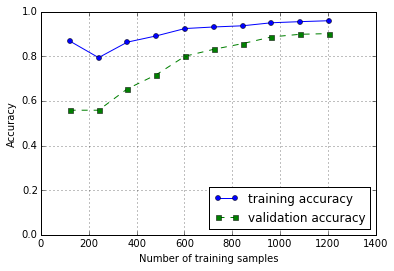

confusion matrix:
[[309  16]
 [ 50 285]]
()


('VotingClassifier',
 0.90000000000000002,
 0.004354000091552734,
 0.0035598278045654297)

In [618]:
benchmark(N, X, y, learn_curve=True)